# Dfsu - Write huge file

The Dataset.to_dfs() method is the primary way of writing dfs files in MIKE IO. In some case, however, the data we want to write to a file is larger than the system memory and we will therefore not be able to store it in a Dataset before writing to disk. 

This notebook shows how to write larger-than-memory data to a dfsu file.

In [1]:
import numpy as np
import pandas as pd
import mikeio

In [2]:
mesh_file = "../tests/testdata/north_sea_2.mesh"
msh = mikeio.open(mesh_file)
msh.geometry

Flexible Mesh Geometry: Dfsu2D
number of nodes: 1296
number of elements: 2259
projection: LONG/LAT

In [3]:
time = pd.date_range("2018-1-1", end="2018-2-1", freq="D")
dt_seconds = (time[1] - time[0]).total_seconds()
xy = msh.geometry.element_coordinates[:,:2]

In [4]:
# the "data" to be written to file
item1 = mikeio.ItemInfo("Item1", mikeio.EUMType.Water_Level)
def func1(t, x, y):
    t = np.atleast_1d(t)
    data = np.zeros(shape=(len(t), len(x)))
    for j in range(len(t)):
        data[j,:] = 0.01*t[j]*np.cos(0.2*x)*np.sin(2*y)
    return data

item2 = mikeio.ItemInfo("Item2", mikeio.EUMType.Water_Level)
def func2(t, x, y):
    t = np.atleast_1d(t)
    data = np.zeros(shape=(len(t), len(x)))
    for j in range(len(t)):
        data[j,:] = 0.01*(3-t[j])*np.cos(0.4*x)*np.sin(0.8*y)    
    return data

## Option 1: Dataset with one timestep and append()

1. Create first a Dataset ds only containing the first timestep
2. Use dfs.write(..., keep_open=True) to write the header and the first time step to disk
3. Write additional timesteps with dfs.append(...)
4. close with dfs.close()

In [5]:
data10 = func1(t=0, x=xy[:,0], y=xy[:,1])
da1 = mikeio.DataArray(data=data10, time=time[0], geometry=msh.geometry, item=item1)

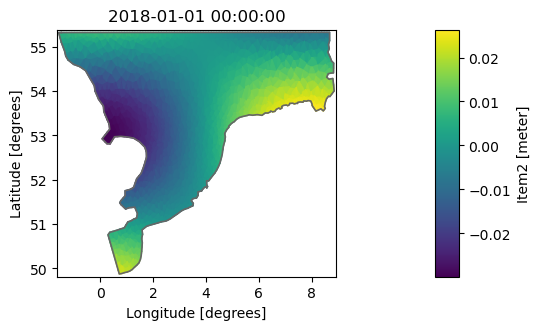

In [6]:
data20 = func2(t=0, x=xy[:,0], y=xy[:,1])
da2 = mikeio.DataArray(data=data20, time=time[0], geometry=msh.geometry, item=item2)
da2.plot();

In [7]:
ds = mikeio.Dataset([da1, da2])
ds

<mikeio.Dataset>
dims: (time:1, element:2259)
time: 2018-01-01 00:00:00 (time-invariant)
geometry: Dfsu2D (2259 elements, 1296 nodes)
items:
  0:  Item1 <Water Level> (meter)
  1:  Item2 <Water Level> (meter)

In [8]:
dfs = mikeio.Dfsu(mesh_file)

In [9]:
fn = "bigfile1.dfsu"
with dfs.write(fn, data=ds, dt=dt_seconds, keep_open=True) as f:
    for tj in time[1:]:
        t = (tj - time[0]).total_seconds()
        ds[0].values = func1(t, x=xy[:,0], y=xy[:,1])
        ds[1].values = func2(t, x=xy[:,0], y=xy[:,1])
        ds.time = tj
        f.append(ds)

## Option 2: Dfsu.write_header()

The older option is to use dfs.write_header() 

In [10]:
dfs = mikeio.Dfsu(mesh_file)

In [11]:
fn = "bigfile2.dfsu"
with dfs.write_header(fn, start_time=time[0], dt=dt_seconds, items=[item1, item2]) as f:
    for tj in time:
        t = (tj - time[0]).total_seconds()
        data1 = func1(t, x=xy[:,0], y=xy[:,1])
        data2 = func2(t, x=xy[:,0], y=xy[:,1])
        f.append(data=[data1, data2])

## Clean up

In [12]:
import os
os.remove("bigfile1.dfsu")
os.remove("bigfile2.dfsu")